In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\mdurh\AppData\Local\Temp\ipykernel_13056\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [40]:
import tqdm
import pandas as pd
pd.set_option('display.max_colwidth', 150)
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# exploration

In [41]:
#import train data
train = pd.read_csv("data/training_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)
test = pd.read_csv("data/dev_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)

In [42]:
# size of the dataset and null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  14000 non-null  object
 1   emotion   14000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 218.9+ KB


In [43]:
# check if the emotions are correctly defined:
print(np.sort(train['emotion'].unique()))

# check the distribution of sentences in each emotion class:
df = train.groupby('emotion').count().reset_index()
sum_total = df['sentence'].sum()
df['perc_total'] = round(df['sentence']/sum_total,2)
df

[1 2 3 4 5 6 7 8]


,emotion,sentence,perc_total
0,1,2999,0.21
1,2,2129,0.15
2,3,1343,0.10
3,4,1442,0.10
4,5,1470,0.10
5,6,1384,0.10
6,7,1138,0.08
7,8,2095,0.15


# Baseline

In [44]:
#minimal preprocessing
train.dropna(inplace=True)
train.emotion=train.emotion-1
train.emotion=train.emotion.astype("int")
train= train.reset_index(drop=True)

In [45]:
#feature extraction 
vectorizer = TfidfVectorizer(stop_words="english", max_df=.8)
X = vectorizer.fit_transform(train.sentence).toarray()
Y = train.emotion
X.shape, Y.shape

((14000, 7185), (14000,))

In [46]:
#applying the same steps to validation data
val = pd.read_csv("data/dev_set.txt",sep=" .	",engine='python', names=["sentence","emotion"],skiprows=1 )
val.dropna(inplace=True)
val.emotion=val.emotion-1
val.emotion=val.emotion.astype("int")
val= val.reset_index(drop=True)

X_test = vectorizer.transform(val.sentence).toarray()
Y_test = val.emotion
X_test.shape, Y_test.shape

((968, 7185), (968,))

In [47]:
clf = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced').fit(X, Y)
Y_pred = clf.predict(X_test)

In [48]:
score = clf.score(X_test, Y_test)
print('accuracy: ', score)

accuracy:  0.32541322314049587


In [49]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(Y_test, Y_pred)}\n"
)

Classification report for classifier LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0):
              precision    recall  f1-score   support

           0       0.41      0.21      0.28       205
           1       0.38      0.38      0.38       165
           2       0.14      0.28      0.19        72
           3       0.33      0.37      0.35       102
           4       0.38      0.45      0.41        97
           5       0.31      0.35      0.33        81
           6       0.32      0.44      0.37        94
           7       0.37      0.26      0.30       152

    accuracy                           0.33       968
   macro avg       0.33      0.34      0.33       968
weighted avg       0.35      0.33      0.33       968




# Preprocessing

Now that we have a baseline score (.214), we can try additional preprocessing to improve the score, as well as different models and embessing layers.

In [50]:
def preprocessing(dataframe, column):
    
    processed_corpus = []
    stop_words = set(stopwords.words("english"))
    
    for i in (range(len(dataframe))):
        text = dataframe[column].iloc[i]
        
        # Remove tags
        text = BeautifulSoup(text).get_text()
        
        # Remove punctuations - mantain only the final . or !
        text = re.sub("[^a-zA-z!.?:'\s]", '', text)
        text = re.sub("[.]{2,}", '', text)
        text = re.sub("[?]", "questionmark", text)
        text = re.sub("[!]", "exclamationmark", text)

        # Convert to lowercase
        text = text.lower()        
        
        # Convert to list from string
        text = text.split()

        # Lemmatization
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in stop_words] 
        text = " ".join(text)
        processed_corpus.append(text)
    dataframe['sentence_prep'] = processed_corpus
        
    return dataframe

In [51]:
#reimport data
train = pd.read_csv("data/training_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)
test = pd.read_csv("data/dev_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)

In [52]:
train = preprocessing(train, 'sentence')

C:\Users\mdurh\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [53]:
train.sample(10)

,sentence,emotion,sentence_prep
12447,"Listen , I - I know you're gonna think this is real dumb of me , but , uh , I haven't been feeling very good lately , and , uh ...",2,listen know gonna think real dumb uh feeling good lately uh
7142,At least they can dream .,5,least dream .
1232,"You're not gonna give him a chance , are you ?",4,gonna give chance questionmark
8071,How can you be so mean ?,3,mean questionmark
5589,What if I could get you the money you're waiting for before midnight ?,8,could get money waiting midnight questionmark
11313,I shall wish a book jacket that is only letters .,8,shall wish book jacket letter .
11745,"With what money , and what about us ?",4,money u questionmark
3925,Want to see a strange object ?,2,want see strange object questionmark
11309,Wait till I ask Dad if this is any way to run an airline .,1,wait till ask dad way run airline .
10322,I'd like to introduce you to ...,2,i'd like introduce


In [54]:
#feature extraction 
vectorizer = TfidfVectorizer(stop_words=None, max_df=.8, strip_accents='unicode', lowercase=False, analyzer='word')
X = vectorizer.fit_transform(train['sentence_prep']).toarray()
Y = train['emotion']
X.shape, Y.shape

((14000, 6582), (14000,))

In [55]:
test = preprocessing(test, 'sentence')

In [56]:
X_test = vectorizer.transform(test['sentence_prep']).toarray()
Y_test = test['emotion']
X_test.shape, Y_test.shape

((1000, 6582), (1000,))

## Model - LogisticRegression

In [57]:
clf = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced').fit(X, Y)
Y_pred = clf.predict(X_test)

In [58]:
score = clf.score(X_test, Y_test)
print('accuracy: ', score)

accuracy:  0.361


In [59]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(Y_test, Y_pred)}\n"
)

Classification report for classifier LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0):
              precision    recall  f1-score   support

           1       0.48      0.26      0.34       211
           2       0.39      0.35      0.37       170
           3       0.24      0.38      0.29        77
           4       0.33      0.38      0.35       104
           5       0.40      0.45      0.43        97
           6       0.27      0.37      0.31        87
           7       0.34      0.47      0.39        96
           8       0.44      0.36      0.40       158

    accuracy                           0.36      1000
   macro avg       0.36      0.38      0.36      1000
weighted avg       0.39      0.36      0.36      1000




In [60]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
print(cm)
cm = pd.DataFrame(cm, index=range(1,9), columns=range(1,9))

[[55 21 32 26  8 26 26 17]
 [14 60 16 16 17  9 23 15]
 [ 8 10 29  5  4  6  7  8]
 [ 7  7  9 39  3 18 10 11]
 [ 4  6  8  4 44 10  9 12]
 [11 12  8  6  7 32  5  6]
 [ 3 15  3 14  4  8 45  4]
 [12 21 18  8 23 10  9 57]]


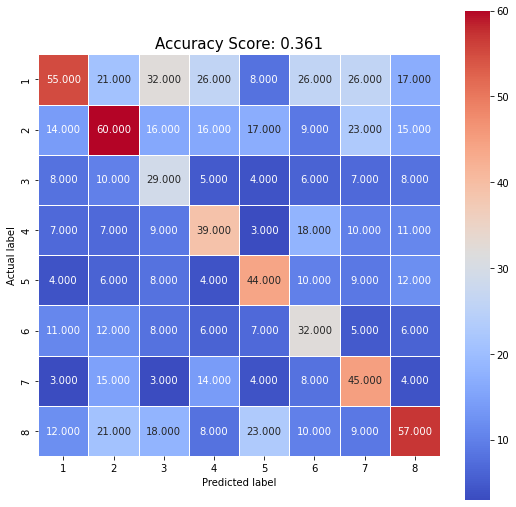

In [61]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [62]:
feature_names = vectorizer.get_feature_names_out()

In [30]:
print(feature_names)

['aa' 'aarfy' 'abandoned' 'abandoning' 'abdominal' 'abercrombie' 'abide'
 'ability' 'able' 'ably' 'aboard' 'abracadabra' 'absence' 'absolute'
 'absolutely' 'absolve' 'absolved' 'absurd' 'absurdly' 'abundance' 'abuse'
 'abused' 'abusive' 'accent' 'accept' 'acceptable' 'accepted' 'accepts'
 'access' 'accessory' 'accident' 'accommodate' 'accomplish' 'according'
 'account' 'accountable' 'accountant' 'accusation' 'accuse' 'accused'
 'accuses' 'ace' 'ache' 'ached' 'aching' 'acid' 'acknowledge'
 'acknowledging' 'acquaintance' 'acquainted' 'acquisition' 'acre' 'across'
 'act' 'acted' 'acting' 'action' 'active' 'activity' 'actress' 'actual'
 'actually' 'ad' 'adalind' 'add' 'addicted' 'additional' 'address' 'adept'
 'adiran' 'administration' 'administrative' 'admiral' 'admire' 'admired'
 'admiring' 'admission' 'admit' 'admitting' 'adolescence' 'adolescent'
 'adopt' 'adopted' 'adoption' 'adore' 'adrian' 'adrift' 'adult' 'advance'
 'advantage' 'adventure' 'advertising' 'advice' 'advise' 'adviser'
